In [ ]:
#the algorithms used below is provided in the aif360 toolbox cited in the report
#example notebooks referred

In [5]:
#importing necessary libraries
import pandas as pd 
import numpy as np
import seaborn as sns
import sklearn as sklearn
import matplotlib
import os
import cvxpy as cp

from tqdm import tqdm
from matplotlib import pyplot as plt


from sklearn.preprocessing import LabelEncoder
from aif360.datasets import StandardDataset

from aif360.metrics import BinaryLabelDatasetMetric
from IPython.display import Markdown, display

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

from aif360.algorithms.preprocessing.reweighing import Reweighing

from aif360.metrics import ClassificationMetric
from collections import OrderedDict

In [6]:
#setting directory
#path="/Users/nazeeha/Downloads"
#os.chdir(path)

In [7]:
#load data
df = pd.read_csv("ASSIDATA_CE888.csv" , dtype = str)

In [8]:
#the first row is a subheading for the coloumns which seems redundant since the coloumn names are self-explanatory,hence droping first row
df = df.drop(index=[0] , axis=0)

In [9]:
#the algorithms require restricted features hence dropping a few, this is part of pre-processing
df = df.drop(df.columns[[0,1,2,3,6,8,9,10,11, 14,15,17,20,22, 23, 24, 25,26,27, 28, 29, 30, 31, 32, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44 ,45, 46 ]] , axis=1)

In [10]:
#view data
df.head()

,OFFICER_GENDER,OFFICER_RACE,OFFICER_YEARS_ON_FORCE,SUBJECT_RACE,SUBJECT_GENDER,SUBJECT_WAS_ARRESTED,SUBJECT_OFFENSE,REPORTING_AREA,SECTOR,INCIDENT_REASON,REASON_FOR_FORCE
1,Male,Black,2,Black,Female,Yes,APOWW,2062,130,Arrest,Arrest
2,Male,White,17,Hispanic,Male,Yes,APOWW,1197,230,Arrest,Arrest
3,Male,Black,1,Hispanic,Male,Yes,APOWW,4153,430,Arrest,Arrest
4,Male,Black,24,White,Female,Yes,Evading Arrest,4523,640,Arrest,Arrest
5,Male,White,7,Black,Male,No,Other Misdemeanor Arrest,2167,340,Arrest,Arrest


In [10]:
#dropping null values 
df = df.dropna()

In [11]:
#renaming the protected attributes , so that it is easier to mention protected groups for use in algorithm
df = df.rename(columns= {"SUBJECT_RACE" : "race" , "SUBJECT_GENDER" : "sex" })

## Pre-processing raw data into StructuredDataset

In [13]:
#code defined for preprocessing into StandardDataset class, referred from 
#"https://github.com/Trusted-AI/AIF360/blob/master/aif360/algorithms/preprocessing/optim_preproc_helpers/data_preproc_functions.py"
#StandardDataset mapping referred from "https://github.com/Trusted-AI/AIF360/blob/746e763191ef46ba3ab5c601b96ce3f6dcb772fd/aif360/datasets/standard_dataset.py#L9"

def load_preproc_data(protected_attributes=None):
    def custom_preprocessing(df):
        
         # Restrict races to White and Black
        dfcutG = df.loc[~df["race"].isin(["American Ind","Hispanic","Asian","Other"]),:]
        
         #Restrict sex to male and female
        dfcutG = df.loc[~df["sex"].isin(["Unknown"]),:]

        # Restrict the features to use
        dfcutG = dfcutG[["race" , "sex", "SUBJECT_WAS_ARRESTED"]]

        def group_race(x):
            if x == "White":
                return 1.0
            else:
                return 0.0

        # Recode sex and race
        dfcutG["sex"] = dfcutG["sex"].replace({"Female": 1.0, "Male": 0.0})
        dfcutG["race"] = dfcutG["race"].apply(lambda x: group_race(x))

        return dfcutG
    XD_features = ['race' , 'sex',"SUBJECT_OFFENSE" , "REPORTING_AREA"] #all features
    D_features = ['sex' , 'race']  if protected_attributes is None else protected_attributes #protected attributes
    Y_features = ['SUBJECT_WAS_ARRESTED'] #label
    X_features = list(set(XD_features)-set(D_features))
    categorical_features = ["SUBJECT_OFFENSE" , "REPORTING_AREA" ] #mentioned for one-hot encoding in the StandardDataset
    all_privileged_classes = {"sex": [1.0],
                              "race": [1.0]}
    all_protected_attribute_maps = {"sex": {0.0: 'Male', 1.0: 'Female'},    #protected attribute mapping
                                    "race": {1.0: 'White', 0.0: 'Black'}}

#Specifying standard class mapping
    return StandardDataset(
        df = dfcutG ,
        label_name = Y_features[0],
        favorable_classes = ["No"],
        protected_attribute_names = D_features,
        privileged_classes = [all_privileged_classes[x] for x in D_features],
        instance_weights_name=None, 
        categorical_features= categorical_features, 
        features_to_keep=X_features+Y_features+D_features, 
        na_values=[],
        custom_preprocessing=custom_preprocessing, 
        metadata={'label_maps': [{1.0: 'No', 0.0: 'Yes'}],
                  'protected_attribute_maps': [all_protected_attribute_maps[x]
                                for x in D_features]})
       

### Loading StandardDataset

In [14]:
#loading StandardDataset, i.e, structured dataset required by algorithm
df_orig = load_preproc_data(["race"])  #here, only 'race' is added as the protected attribute

In [16]:
#mapping for the privileged and unprivileged group, required for use in Metric class 
privileged_groups = [{"race" : 1}] # White 
unprivileged_groups = [{"race": 0 }] # Black 

## Bias detection

In [50]:
#bias detected for whole dataset, Statistical Parity Difference (SPR) is calculated using Metric class from aif360
#https://github.com/Trusted-AI/AIF360/blob/746e763191ef46ba3ab5c601b96ce3f6dcb772fd/aif360/metrics/binary_label_dataset_metric.py

metric_orig_dataset = BinaryLabelDatasetMetric(df_orig, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_dataset.mean_difference())

#### Original dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.128303


In [21]:
#test_train_val split

df_orig_train, df_orig_vt = df_orig.split([0.7], shuffle=True)
df_orig_valid , df_orig_test = df_orig_vt.split([0.5] , shuffle = True)

In [22]:
#bias measure for Original train data

metric_orig_train = BinaryLabelDatasetMetric(df_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.128937


In [51]:
#bias measure for Original test data

metric_orig_test = BinaryLabelDatasetMetric(df_orig_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Original test dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.092812


## Reweighing

In [25]:
#re-weighing algorithm from "https://github.com/Trusted-AI/AIF360/blob/746e763191ef46ba3ab5c601b96ce3f6dcb772fd/aif360/algorithms/preprocessing/reweighing.py"

RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)

In [26]:
#reweighing
RW = RW.fit(df_orig_train)

In [27]:
#transforming Original train data to Transformed train data
df_rw_transf_train = RW.transform(df_orig_train)

In [33]:
#transform Original test data
df_rw_transf_test = RW.transform(df_orig_test)

In [29]:
#testing
assert np.abs(df_rw_transf_train.instance_weights.sum()-df_orig_train.instance_weights.sum())<1e-6

In [30]:
#measuring SPR for transformed train data
metric_rw_transf_train = BinaryLabelDatasetMetric(df_rw_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_rw_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


In [52]:
#measuring SPR for transformed test data
metric_rw_transf_test = BinaryLabelDatasetMetric(df_rw_transf_test, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_rw_transf_test.mean_difference())

#### Transformed test dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.033123


## Original classifier

### Training classifier on Original train data

In [35]:
#standardization
scale_rw_orig = StandardScaler() #for scaling
X_rw_train = scale_rw_orig.fit_transform(df_orig_train.features) #standardize training features, scaling to unit variance
y_rw_train = df_orig_train.labels.ravel()    
w__rw_train = df_orig_train.instance_weights.ravel()  #specifiying original weights

In [36]:
#training on LogisticRegressor
lmod = LogisticRegression()
lmod.fit(X_rw_train, y_rw_train, 
         sample_weight=df_orig_train.instance_weights)
y_rw_train_pred = lmod.predict(X_rw_train) #predictions

In [37]:
#positive class index
pos_ind = np.where(lmod.classes_ == df_orig_train.favorable_label)[0][0]

In [38]:
#defining predictions
df_orig_train_pred = df_orig_train.copy()

df_orig_train_pred.labels = y_rw_train_pred

#### Obtain scores for original validation and test set 

In [39]:
df_orig_valid_pred = df_orig_valid.copy(deepcopy=True) #getting validation set values
X_rw_valid = scale_rw_orig.transform(df_orig_valid_pred.features) #scaling 
y_rw_valid = df_orig_valid_pred.labels  #define predictions for val set 
df_orig_valid_pred.scores = lmod.predict_proba(X_rw_valid)[:,pos_ind].reshape(-1,1)  #getting scores for validation set

In [40]:
#same process on original test data
df_orig_test_pred = df_orig_test.copy(deepcopy=True)  
X_rw_test = scale_rw_orig.transform(df_orig_test_pred.features)
y_rw_test = df_orig_test_pred.labels
df_orig_test_pred.scores = lmod.predict_proba(X_rw_test)[:,pos_ind].reshape(-1,1)

### Obtain optimal threshold from validation scores

In [41]:
#algorithm for obtaining optimal threshold "https://github.com/Trusted-AI/AIF360/blob/746e763191ef46ba3ab5c601b96ce3f6dcb772fd/examples/demo_reweighing_preproc.ipynb"
#algorithm for ClassificationMetric from "https://github.com/Trusted-AI/AIF360/blob/746e763191ef46ba3ab5c601b96ce3f6dcb772fd/aif360/metrics/classification_metric.py"
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = df_orig_valid_pred.scores > class_thresh
    df_orig_valid_pred.labels[fav_inds] = df_orig_valid_pred.favorable_label        #setting classification thresholds
    df_orig_valid_pred.labels[~fav_inds] = df_orig_valid_pred.unfavorable_label     #for favourable and unfavourable label
    
    classified_metric_orig_valid = ClassificationMetric(df_orig_valid,
                                             df_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,  #get classification metrics
                                             privileged_groups=privileged_groups)      #includes accuracy
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]     
best_class_thresh = class_thresh_arr[best_ind]         #calculate optimal threshold

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.6319
Optimal classification threshold (no reweighing) = 0.5643


In [42]:
#code for computing metrics from predictions from classifiers. adopted from "https://github.com/Trusted-AI/AIF360/blob/master/examples/common_utils.py"
def compute_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

## Metrics for predictions from the original classifier

In [ ]:
#several metrics are displayed here, I included them in the code to understand perfomance better
#but in the report only accuracy, Average Odds Difference are defined and hence used for comparisons.

In [43]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = df_orig_test_pred.scores > thresh
    df_orig_test_pred.labels[fav_inds] = df_orig_test_pred.favorable_label
    df_orig_test_pred.labels[~fav_inds] = df_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(df_orig_test, df_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

100%|██████████| 100/100 [00:00<00:00, 810.90it/s]

Classification threshold used = 0.5643
Balanced accuracy = 0.5841
Statistical parity difference = -0.1520
Disparate impact = 0.5217
Average odds difference = -0.1448
Equal opportunity difference = -0.1654
Theil index = 0.2745


#### Balanced accuracy vs Average odds difference graph for original classifier

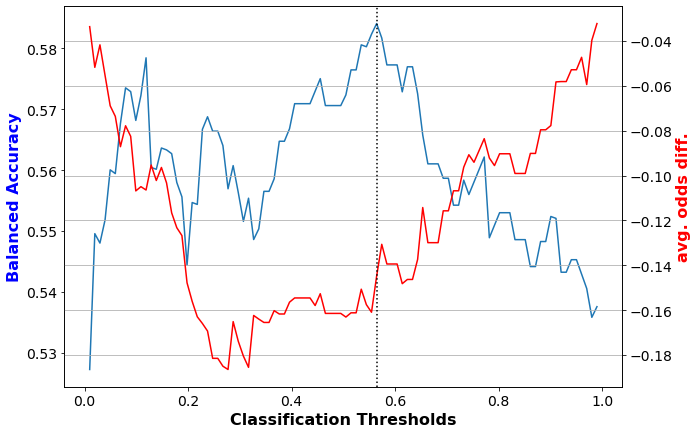

In [44]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

# Transformed classifier

### Training classifier on transformed train data

In [45]:
scale_rw_transf = StandardScaler()      #for standardization, same scaler used as original train data
X_train = scale_rw_transf.fit_transform(df_rw_transf_train.features)    #scaling to unit variance the transformed 
y_train = df_rw_transf_train.labels.ravel()                             #train data and specifying weights

lmod = LogisticRegression()             #training on logistic regressor
lmod.fit(X_train, y_train,
        sample_weight=df_rw_transf_train.instance_weights)
y_train_pred = lmod.predict(X_train)

### Obtain scores from transformed test data

In [46]:
df_transf_test_pred = df_rw_transf_test.copy(deepcopy=True)
X_test = scale_rw_transf.fit_transform(df_transf_test_pred.features)
y_test = df_transf_test_pred.labels
df_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

## Metrics for predictions from transformed classifier

In [48]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = df_transf_test_pred.scores > thresh
    df_transf_test_pred.labels[fav_inds] = df_transf_test_pred.favorable_label
    df_transf_test_pred.labels[~fav_inds] = df_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(df_rw_transf_test, df_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

100%|██████████| 100/100 [00:00<00:00, 732.56it/s]

Classification threshold used = 0.5643
Balanced accuracy = 0.5777
Statistical parity difference = -0.0485
Disparate impact = 0.7850
Average odds difference = -0.0309
Equal opportunity difference = 0.0301
Theil index = 0.2874


#### Balanced accuracy vs Average Odds Difference graph for transformed classifier

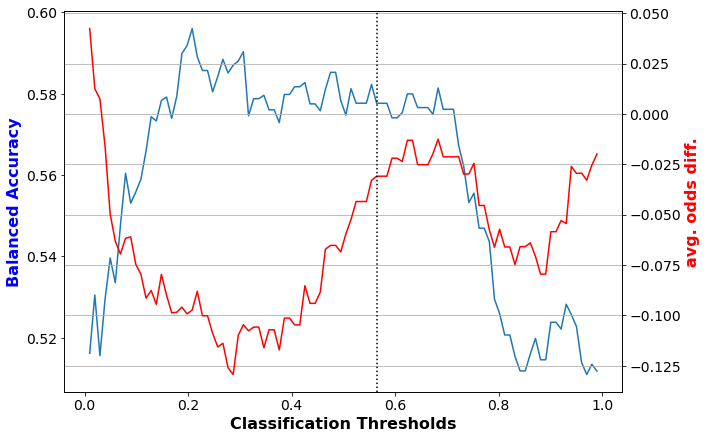

In [49]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)